In [25]:
from math import pi, sin, cos

import neat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

N = 20000
T = 1
d = 0.001
# d = 0
S = 64

inputs = [(x,) for x in np.linspace(-pi, pi, 100)]
output_func = lambda x, n: (sin(x) if x > 0 else cos(x)) ** (1 + d * n // T)
# output_func = lambda x, n: abs(sin(x)) ** (1 + d * n // T)
outputs = []
actual_outputs = []


def eval_genomes(genomes, config):
    idx = np.random.choice(np.arange(len(inputs)), S, replace=False)
    XI, XO = np.array(inputs)[idx], np.array(outputs)[idx]

    for genome_id, genome in genomes:
        genome.fitness = 0.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(XI, XO):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2

In [26]:
def run(config_file):
    global outputs
    global actual_outputs

    # Load configuration.
    config = neat.Config(
        neat.DefaultGenome,
        neat.DefaultReproduction,
        neat.DefaultSpeciesSet,
        neat.DefaultStagnation,
        config_file,
    )

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    # p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)

    # Run for up to 300 generations.
    history = []
    for n in range(N):
        outputs = [(output_func(x[0], n),) for x in inputs]
        winner = p.run(eval_genomes, 1)
        history.append(winner.fitness)

    axes = sns.relplot(x=[x for x in range(0, len(history))], y=history, kind="line")
    axes.set(xlabel="Generation", ylabel="Fitness")

    # Display the winning genome.
    print("\nBest genome:\n{!s}".format(winner))

    # Show output of the most fit genome against training data.
    print("\nOutput:")
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(inputs, outputs):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    actual_outputs = [winner_net.activate(i) for i in inputs]


Best genome:
Key: 2343883
Fitness: -1.7731436153261253
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.028086709682986682, response=1.4039252456307296, activation=hat, aggregation=mean)
	6545 DefaultNodeGene(key=6545, bias=0.7821387983410747, response=7.979198235786981, activation=sigmoid, aggregation=product)
Connections:
	DefaultConnectionGene(key=(-1, 0), weight=-2.7706029609585485, enabled=True)
	DefaultConnectionGene(key=(-1, 6545), weight=7.34949726364615, enabled=True)
	DefaultConnectionGene(key=(6545, 0), weight=4.38463251583562, enabled=True)

Output:
input (-3.141592653589793,), expected output (1.0,), got [0.0]
input (-3.0781261353354537,), expected output (0.9604944646605069,), got [0.0]
input (-3.0146596170811146,), expected output (0.850820172131552,), got [0.0]
input (-2.951193098826775,), expected output (0.6943829569361653,), got [0.0]
input (-2.887726580572436,), expected output (0.5212509148820216,), got [0.0]
input (-2.8242600623180967,), expected output (0.35902303500580

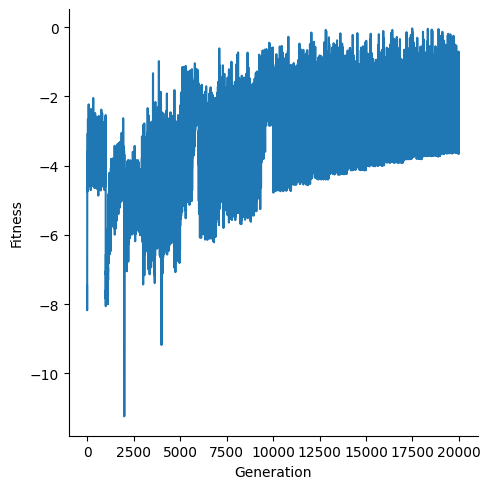

In [27]:
# Determine path to configuration file. This path manipulation is
# here so that the script will run successfully regardless of the
# current working directory.
config_path = "neat-test.ini"
run(config_path)

[Text(0.5, 0, 'X'), Text(0, 0.5, 'Y')]

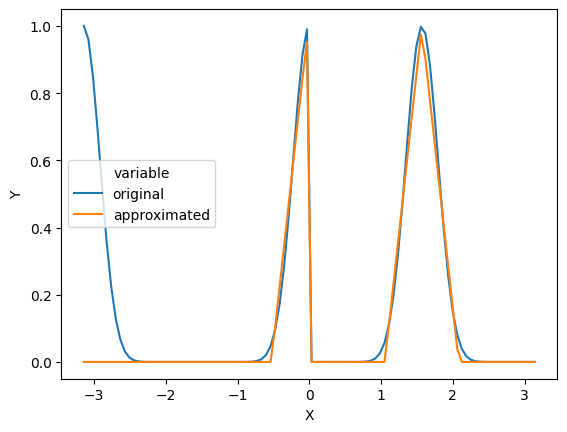

In [28]:
import pandas as pd

data = pd.DataFrame({
    "input": [i[0] for i in inputs],
    "original": [e[0] for e in outputs],
    "approximated": [o[0] for o in actual_outputs],
})

axes = sns.lineplot(x="input", y="value", hue="variable", data=pd.melt(data, "input"))
axes.set(xlabel="X", ylabel="Y")